<a href="https://colab.research.google.com/github/YTIputi/Detection/blob/main/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Requirements**

In [2]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 19.1 MB/s eta 0:00:00


# **Detection**

In this notebook I will give an example of solving a detection problem

---

## **Libraries**

In [52]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchvision import transforms

import cv2
from google.colab.patches import cv2_imshow

from tqdm import tqdm

---

## **Dataset**

**About Dataset**

The dataset comprises 16.7k images and 2 annotation files, each in a distinct format. The first file, labeled "Label," contains annotations with the original scale, while the second file, named "yolo_format_labels," contains annotations in YOLO format. The dataset was obtained by employing the OIDv4 toolkit, specifically designed for scraping data from Google Open Images. Notably, this dataset exclusively focuses on face detection.

This dataset offers a highly suitable resource for training deep learning models specifically designed for face detection tasks. The images within the dataset exhibit exceptional quality and have been meticulously annotated with bounding boxes encompassing the facial regions. The annotations are provided in two formats: the original scale, denoting the pixel coordinates of the bounding boxes, and the YOLO format, representing the bounding box coordinates in normalized form.

The dataset was meticulously curated by scraping relevant images from Google Open Images through the use of the OIDv4 toolkit. Only images that are pertinent to face detection tasks have been included in this dataset. Consequently, it serves as an ideal choice for training deep learning models that specifically target face detection tasks.



In [2]:
path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")
os.listdir(path)

100%|██████████| 4.43G/4.43G [01:52<00:00, 42.4MB/s]

Extracting files...


['labels2', 'images', 'labels']

I am developing DetectionData to solve the face detection problem for a fixed number of faces. I keep images that have the specified number of faces. However, images with fewer faces can also be kept by simply adding [0, 0, 0, 0] to the target values to fill the missing labels.

In [57]:
class DetectionData(data.Dataset):
    def __init__(self, path, face=1, train=True, transform=None):
        super().__init__()
        self.face = face
        self.transform = transform

        self.path_images = os.path.join(path, 'images', 'train' if train else 'val')
        self.path_labels = os.path.join(path, 'labels', 'train' if train else 'val')

        filtered_images = []
        for fname in os.listdir(self.path_images):
            label_path = os.path.join(self.path_labels, fname.replace('.jpg', '.txt'))
            if not os.path.exists(label_path):
                continue
            with open(label_path, 'r') as f:
                lines = f.readlines()
            if len(lines) == self.face:
                filtered_images.append(fname)

        self.images = filtered_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.path_images, self.images[index])
        label_path = os.path.join(self.path_labels, self.images[index].replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = gray / 255.0
        image_tensor = torch.tensor(gray, dtype=torch.float32).unsqueeze(0)

        labels = []
        with open(label_path, 'r') as f:
            for _ in range(self.face):
                line = f.readline()
                parts = line.strip().split()
                coords = list(map(float, parts[1:]))
                labels.append(coords)

        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, labels_tensor


Although I work with images of varying sizes, they are typically resized to a common shape in practice so that the model can be trained in batches. However, due to the specific tensor structure in my case, I will train the model using a batch size of one.

In [58]:
data_train = DetectionData(path=path, train=True)
loader_train = data.DataLoader(data_train, batch_size=1, shuffle=True)

**Displaying an image**

In [60]:
def display(index, data):
    img = data[index][0].squeeze(0).numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    h, w = img.shape[:2]

    for label in data[index][1]:
      x_center, y_center, width, height = label

      x_center_px = x_center * w
      y_center_px = y_center * h
      width_px = width * w
      height_px = height * h

      box_side = int(max(width_px, height_px))

      x1 = int(x_center_px - box_side / 2)
      y1 = int(y_center_px - box_side / 2)
      x2 = int(x_center_px + box_side / 2)
      y2 = int(y_center_px + box_side / 2)

      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2_imshow(img)

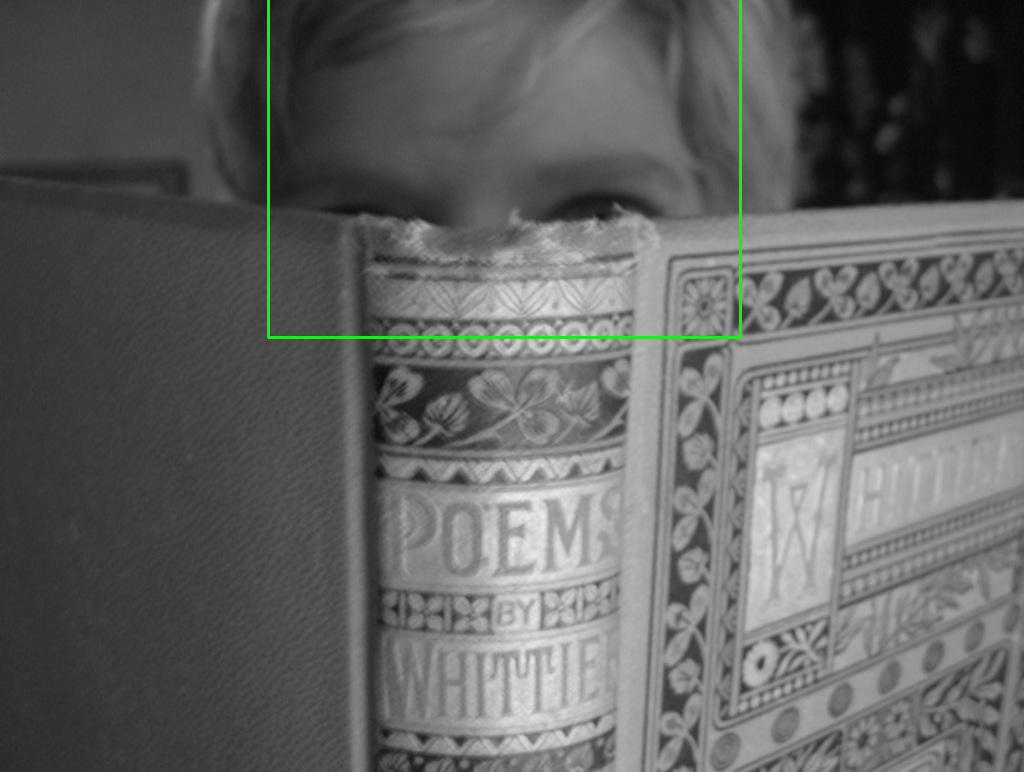

In [61]:
display(103, data_train)

---

## **Model**

I will create a simple model consisting of an encoder, which processes images and outputs a context vector, and a decoder based on LSTM layers.

In [62]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.adaptive = nn.AdaptiveAvgPool2d((7, 7))

    self.lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = self.pool1(x)

    x = F.relu(self.layer2(x))
    x = self.pool2(x)

    x = F.relu(self.layer3(x))
    x = self.pool3(x)

    x = F.relu(self.layer4(x))
    x = self.pool4(x)

    x = F.relu(self.layer5(x))
    x = self.adaptive(x)

    x = x.permute(0, 2, 3, 1)
    x = x.view(x.size(0), -1, 512)

    x, _ = self.lstm(x)
    return x

In [63]:
class Decoder(nn.Module):
  def __init__(self, num_faces=1):
    super().__init__()
    self.num_faces = num_faces
    self.lstm1 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
    self.linear = nn.Linear(256, 4 * num_faces)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    output, (h_n, c_n) = self.lstm1(x)
    x = output[:, -1, :]
    x = self.linear(x)
    x = self.sigmoid(x)
    x = x.view(-1, self.num_faces, 4)
    return x

In [64]:
class FaceDetector(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

Training a model on a GPU

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceDetector().to(device)


f_loss = nn.MSELoss()
optimizator = optim.Adam(params=model.parameters(), lr=0.001)

In [66]:
num_epochs = 1
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    loop = tqdm(loader_train, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for X_train, y_train in loop:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = f_loss(y_pred, y_train)

        optimizator.zero_grad()
        loss.backward()
        optimizator.step()

        running_loss += loss.item() * X_train.size(0)
        avg_loss = running_loss / ((loop.n + 1) * loader_train.batch_size)
        loop.set_postfix(loss=avg_loss)

    epoch_loss = running_loss / len(loader_train.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
model.eval();

Epoch 1/1 - Loss: 0.0293


FaceDetector(
  (encoder): Encoder(
    (layer1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (adaptive): AdaptiveAvgPool2d(output_size=(7, 7))
    (lstm): LSTM(512, 512, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(512, 256, batch_first=True)
    (linear): Linear(in_features=256,

We output the result

In [67]:
def display(index, data, model):
    device = next(model.parameters()).device
    img = data[index][0].squeeze(0).numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    h, w = img.shape[:2]

    image_tensor = data[index][0].unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        preds = model(image_tensor)[0].cpu().numpy()

    for label in preds:
        if np.linalg.norm(label) >= 0.1:
            x_center, y_center, width, height = label

            x_center_px = x_center * w
            y_center_px = y_center * h
            width_px = width * w
            height_px = height * h

            box_side = int(max(width_px, height_px))

            x1 = int(x_center_px - box_side / 2)
            y1 = int(y_center_px - box_side / 2)
            x2 = int(x_center_px + box_side / 2)
            y2 = int(y_center_px + box_side / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2_imshow(img)


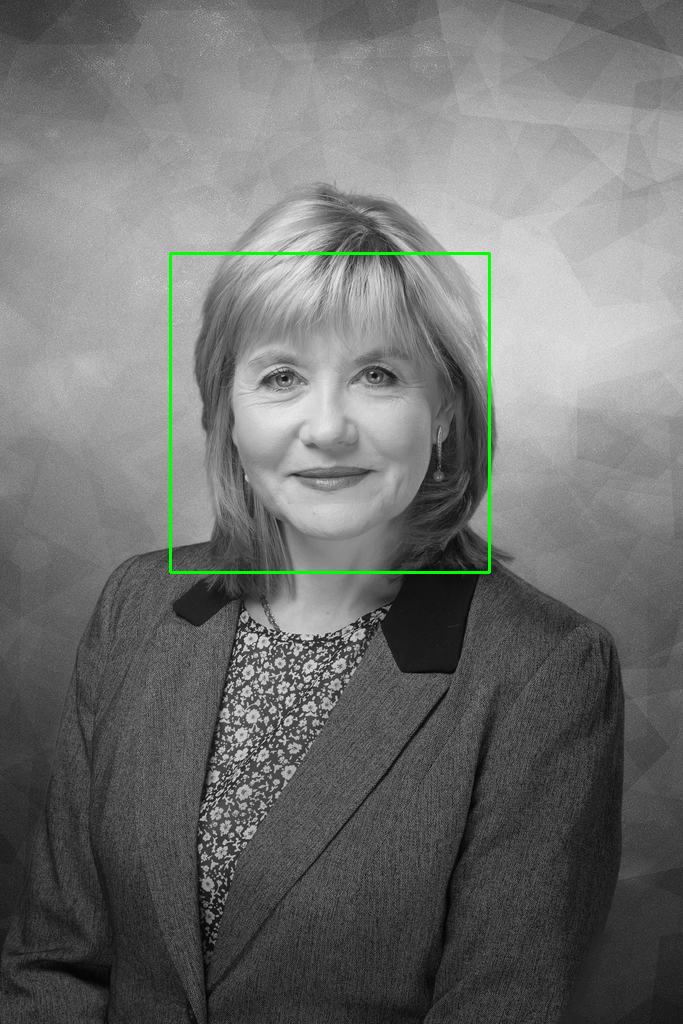

In [75]:
display(1000, data_train, model)

---

## **Summary**

The model's performance was not optimal, which is understandable given the simplicity of the chosen architecture. Additionally, the data preprocessing could have been improved to achieve better results. However, this was sufficient for me, as I gained a clear understanding of the challenges that can arise when tackling such a problem.